# Use Fake-or-Real Dataset for Binary Classification

Compare performance of transformer vs. LSTM at different dataset lengths

### 1. Creating DataLoaders

* Real = 0 label, Fake = 1

* Match Austin's implementation for linear vs. log

In [1]:
from torch.utils.data import Dataset, DataLoader
import torchaudio
import glob
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import random
import torch.nn as nn
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torchsummary import summary

In [2]:
# hyperparameters
class DataConfig:
    sample_rate=16000 # fixed at 16k in for-norm partition
    duration=2 # seconds
    batch_size=16

# DataLoaders
class WaveDataset(Dataset):
    def __init__(self, data_path, label_list, target_sample_rate=DataConfig.sample_rate, duration=DataConfig.duration):
        self.data_path = data_path
        self.label_list = label_list
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration
            
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, index):
        try:
            # load audio with PyTorch
            audio_path_clean = self.data_path[index]
            signal, sr = torchaudio.load(audio_path_clean)

            # making sure audio loaded correctly
            if sr != self.target_sample_rate:
                resampler = T.Resample(sr, self.target_sample_rate)
                signal = resampler(signal)
            if signal.shape[0] > 1:
                signal = torch.mean(signal, axis=0, keepdim=True)
            if signal.shape[1] > self.num_samples:
                signal = signal[:, :self.num_samples]
            if signal.shape[1] < self.num_samples:
                num_missing_samples = self.num_samples - signal.shape[1]
                signal = F.pad(signal, (0, num_missing_samples))
            
            # we are learning from raw waveforms
            # signal == waveform
            #print(torch.squeeze(signal).shape)
            return torch.squeeze(signal), self.label_list[index]
        
        except Exception as e:
            print(f"Error in __getitem__ at index {index}: {str(e)}")
            print(audio_path_clean, signal, sr)
            raise e
        
def get_dataloader(percentage=1.):
    """
    Returns a data loader containing the real and fake voices.
    We are testing different sized subsets of the data to compare LSTM & Transformer.
    So, the "percentage" parameter controls the amount of data we want to use.
    """
    real_train_paths = glob.glob("/home/cameron/voice_data/for-norm/training/real/*.wav")
    fake_train_paths = glob.glob("/home/cameron/voice_data/for-norm/training/fake/*.wav")
    random.shuffle(real_train_paths); random.shuffle(fake_train_paths)

    # let's apply the subset operation here
    # lists are shuffled, so pick the number of samples you want, and select list[:number]
    # similar number of samples (26939 & 26927) in real & fake, so for the original total take their avg
    # we want to keep classes balanced, so do this calculation for both real and fake
    total_num_samples = (len(real_train_paths) + len(fake_train_paths)) / 2
    desired_samples = int(total_num_samples * percentage)
    real_train_paths = list(zip(real_train_paths[:desired_samples], torch.zeros(desired_samples)))
    fake_train_paths = list(zip(fake_train_paths[:desired_samples], torch.ones(desired_samples)))
    #print(len(real_train_paths), len(fake_train_paths))

    # now, concatenate all files, shuffle again, and create the data loader
    # need to shuffle the data & labels in the same way (use zip)
    all_files = real_train_paths + fake_train_paths
    random.shuffle(all_files)
    data, labels = zip(*all_files)
    dataset = WaveDataset(data, labels)
    return DataLoader(dataset, batch_size=DataConfig.batch_size, drop_last=True, shuffle=True, pin_memory=True)

loader = get_dataloader(percentage=1)

In [3]:
example = next(iter(loader))
example

[tensor([[ 0.0428,  0.0436,  0.0419,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0302,  0.0384,  0.0444,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0371, -0.0479, -0.0457,  ..., -0.1140, -0.1606, -0.1455],
         ...,
         [-0.0570, -0.0501, -0.0778,  ..., -0.0039,  0.0247,  0.0202],
         [-0.0904, -0.0959, -0.1022,  ..., -0.2156, -0.2318, -0.2635],
         [ 0.2057,  0.0863, -0.1399,  ...,  0.0251,  0.0205,  0.0220]]),
 tensor([1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.])]

### 1.5 Playing and Plotting Waveforms

torch.Size([32000])


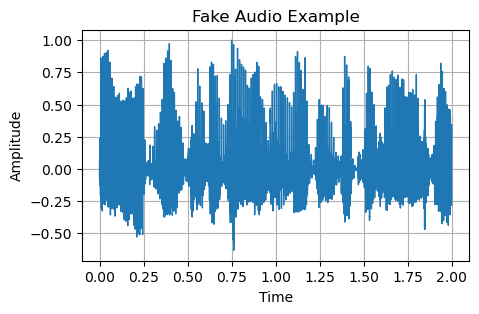

In [4]:
def plot_waveform(waveform, num_label):
    waveform = waveform.numpy()
    num_frames = len(waveform)
    time_axis = torch.arange(0, num_frames) / DataConfig.sample_rate
    text_label = "Real"
    if 1.0 == num_label: text_label = "Fake"
    plt.figure(figsize=(5, 3))
    plt.plot(time_axis, waveform, linewidth=1)
    plt.grid(True)
    plt.title(f"{text_label} Audio Example")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show(block=False)

example = next(iter(loader))
audio = example[0][0]; label = example[1][0]
print(audio.shape)
plot_waveform(audio, label)
ipd.Audio(audio, rate=DataConfig.sample_rate)

### 2. Test it on LSTM

Follow the code from lstm.ipynb from here on out

In [5]:
config = {
    'length': 32000,
    'hidden_size': 64
}

class LSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.length = config['length']
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True, bidirectional=True)
        self.classification_head = nn.Linear(self.length*config['hidden_size']*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.reshape_batch(x)
        z = self.lstm(x)[0]
        z = torch.flatten(z, 1)
        #print(z.shape)
        z = self.classification_head(z)
        return self.sigmoid(z).squeeze(1)
    
    def reshape_batch(self, data):
        return data.unsqueeze(2)

Moving this part to lstm.py

In [6]:
objective = nn.BCELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm = LSTM(config).to(device)
num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(f"Number of parameters in LSTM = {num_params}")
#summary(lstm, (1,48000)) # can't get this to run

lr = 1e-4
n_epochs = 10
optim = torch.optim.Adam(lstm.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(loader)):
        optim.zero_grad()

        # move stuff to the GPU
        # Austin does this in the DataLoader code, but idk how
        X = X.to(device)
        y = y.to(device).float()

        yhat = lstm(X)
        #print(yhat.dtype, y.dtype)
        loss = objective(yhat, y)
        loss.backward()
        losses.append(loss.item())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:", np.mean(losses[-counter:][0]))

Number of parameters in LSTM = 4130305


  0%|          | 11/3366 [00:01<09:44,  5.74it/s]


KeyboardInterrupt: 